## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [1]:
! pip install nltk
! pip install datasets
! pip install tiktoken
! pip install spacy
! pip uninstall -y scipy
! pip install scipy==1.12
! pip install gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
! pip show scipy

Found existing installation: scipy 1.12.0
Uninstalling scipy-1.12.0:
  Successfully uninstalled scipy-1.12.0
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)


[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Name: scipy
Version: 1.12.0
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2024, SciPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions
are met:

1. Redistributions of source code must retain the above copyright
   notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above
   copyright notice, this list of conditions and the following
   disclaimer in the documentation and/or other materials provided
   with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived
   from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRI

In [2]:
import os

import pandas as pd
import s3fs
import zipfile
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize       

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import nltk

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

from itertools import chain
from collections import Counter
import json

### Récupérer les données d'un challenge

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# Lister les challenges
#fs.ls("gvimont/diffusion/hackathon-minarm-2024")

# Lister les fichiers d'un challenge
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")

['civel/diffusion/hackathon-minarm-2024/AIVSAI/.keep',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/all.json',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/train.json']

In [4]:
# Télécharger les données dans le service
PATH_IN = 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip'
fs.download(PATH_IN, 'data/HC3.zip')

# Décompresser les données
with zipfile.ZipFile("data/HC3.zip","r") as zip_file:
    zip_file.extractall("data/")

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

### Exporter des données

In [5]:
def load_jsonl_files():
    file_path = "data/HC3/all.jsonl"
    dfs = pd.read_json(file_path, lines=True)
    return dfs

df = load_jsonl_files()
df

,question,human_answers,chatgpt_answers,index,source
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,NaN,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5
...,...,...,...,...,...
24317,Is rise in pressure from 116/66 to 140/80 norm...,[Hello!Welcome and thank you for asking on HCM...,[It's not uncommon for blood pressure to fluct...,NaN,medicine
24318,What could cause a painless lump in the right ...,"[Hi, * As per my surgical experience, the issu...",[There are several possible causes of a painle...,NaN,medicine
24319,Can Acutret be given to a child for treatment ...,[Although it is difficult to comment whether A...,[It is not appropriate for me to recommend a s...,NaN,medicine
24320,Are BP of 119/65 and pulse of 35 causes for co...,[Welcome and thank you for asking on HCM! I ha...,[It is not uncommon for people with rheumatoid...,NaN,medicine


### Clean questions

In [6]:
def clean_question(question):
    # Remove if question starts with 'Q.'
    return question[3:].strip() if question[:3] == 'Q. ' else question

def clean_questions(df):
    df_cleaned = df.copy()
    
    df_cleaned['question'] = df_cleaned['question'].apply(lambda x: clean_question(x))
    
    return df_cleaned

### Clean Answers

In [7]:
def clean_answer(answer):
    # Transform list answer into string
    return ' '.join(answer) if isinstance(answer, list) else answer

def clean_answers(df):
    df_cleaned = df.copy()
    
    df_cleaned['human_answers'] = df_cleaned['human_answers'].apply(lambda x: clean_answer(x))
    df_cleaned['chatgpt_answers'] = df_cleaned['chatgpt_answers'].apply(lambda x: clean_answer(x))
    
    return df_cleaned

In [8]:
def clean_type_data(df) :
    
    df_cleaned = df.copy()
    df_cleaned['human_answers'].astype(str)
    df_cleaned['chatgpt_answers'].astype(str)
    
    return df_cleaned

### Clean Dataframe

In [9]:
def clean_dataframe(df):
    df = clean_answers(df)
    df = df.drop_duplicates()
    df = clean_questions(df)
    df = clean_type_data(df)
    if 'index' in df.columns :
        df = df.drop(columns="index")
    df = df.dropna()
    
    return df

In [10]:
df = clean_dataframe(df)
df

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5
...,...,...,...,...
24317,Is rise in pressure from 116/66 to 140/80 norm...,Hello!Welcome and thank you for asking on HCM!...,It's not uncommon for blood pressure to fluctu...,medicine
24318,What could cause a painless lump in the right ...,"Hi, * As per my surgical experience, the issue...",There are several possible causes of a painles...,medicine
24319,Can Acutret be given to a child for treatment ...,Although it is difficult to comment whether Ac...,It is not appropriate for me to recommend a sp...,medicine
24320,Are BP of 119/65 and pulse of 35 causes for co...,Welcome and thank you for asking on HCM! I hav...,It is not uncommon for people with rheumatoid ...,medicine


In [11]:
# Export vers un bucket personnel
PATH_OUT = 'misterfacile/diffusion/projet-mongroupe-hackathon/all_dataset.csv'
with fs.open(PATH_OUT, 'w') as file_out:
    df.to_csv(file_out, index=False)

In [12]:
# NB : le dossier 'diffusion' permet un accès en lecture à tous les membres du groupe !
# Tous les membres peuvent donc le voir et l'utiliser dans un service
fs.ls("misterfacile/diffusion/projet-mongroupe-hackathon")

['misterfacile/diffusion/projet-mongroupe-hackathon/all_dataset.csv',
 'misterfacile/diffusion/projet-mongroupe-hackathon/medicine.csv']

In [13]:
with fs.open(PATH_OUT, mode="r") as file_in:
    df_test = pd.read_csv(file_in)
    df_test = clean_dataframe(df_test)

In [14]:
df_test.head()

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5


# Tokenizer

In [15]:
sources = ['finance','wiki_csai','open_qa','medicine','reddit_eli5']
answers_by_source = {source: " ".join(df.loc[df['source'] == source, 'human_answers']) for source in df['source'].unique()}

In [16]:
def nltk_tokenize(doc: str) -> list[str]:
    return word_tokenize(doc)

def gpt_tokenize(doc: str) -> list:
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

In [17]:
def tokenize(doc: str, base_tokenizer=word_tokenize, do_lower=False, do_remove_stop_word=False, custom_stop_words=[], do_lemmatize=False) -> tuple[list,list]:
    if do_lower:
        doc = doc.lower()
    list_token = base_tokenizer(doc)

    if do_remove_stop_word:
        stop_words = en_stop | set("-.!?()_;:,'[]$%*/|\\") | {'...'} | {"''"} | {"``"} | set(custom_stop_words) 
        list_token = [token for token in list_token if token not in stop_words]
        
    if do_lemmatize:
        wnl = WordNetLemmatizer()
        list_token = [wnl.lemmatize(t) for t in list_token]

    return list_token

def use_tokenizer(tokenizer, base_tokenizer=word_tokenize):
    return tokenizer

def remove_stop_words(custom_stop_words):
    return custom_stop_words

def add_stop_words(words, custom_stop_words):
    custom_stop_words.extend(words)
    return custom_stop_words

def lower():
    return True

def lemmatize():
    return True

In [18]:
custom_stop_words = []
list_token_per_source = {}
for source in sources:
    list_token_per_source[source] = tokenize(answers_by_source[source], do_lower=True, do_remove_stop_word=True, custom_stop_words=custom_stop_words)

In [19]:
for source, list_token in list_token_per_source.items():
    word_counts = Counter(list_token)
    top_10_words = word_counts.most_common(10)
    print(source,":\n", top_10_words)

finance :
 [('money', 2654), ('price', 1839), ('tax', 1807), ('stock', 1807), ('pay', 1730), ('market', 1637), ('company', 1632), ('time', 1456), ('income', 1417), ('credit', 1401)]
wiki_csai :
 [('data', 902), ('computer', 580), ('learning', 424), ('systems', 420), ('system', 364), ('information', 358), ('science', 356), ('machine', 326), ('intelligence', 318), ('artificial', 311)]
open_qa :
 [('states', 188), ('united', 170), ('american', 117), ('known', 104), ('world', 60), ('war', 59), ('state', 57), ('city', 51), ('new', 50), ('u.s.', 49)]
medicine :
 [('hi', 467), ('query', 455), ('like', 417), ('hope', 401), ('pain', 384), ('hello', 354), ('need', 322), ('care', 314), ('help', 298), ('consult', 292)]
reddit_eli5 :
 [('like', 20263), ('people', 19320), ('time', 12497), ('way', 9323), ('things', 8575), ('use', 7863), ('different', 7799), ('lot', 7669), ('know', 7166), ('money', 6911)]


In [20]:
file_path = 'list_token_per_source.json'

# Open the file in write mode
with open(file_path, 'w') as json_file:
    # Write the dictionary to the file
    json.dump(list_token_per_source, json_file, indent=4)

print("Dictionary has been written to", file_path)

Dictionary has been written to list_token_per_source.json


# Compare the length of the answer between human and ChatGPT

In [21]:
def compareLengthAnswer(data, category="") :

    #Collect the length of the answer
    if (category == "") :
        lengthHumanAnswer = data['human_answers'].apply(len)
        lengthChatGPTAnswer = data['chatgpt_answers'].apply(len)
    else :
        lengthHumanAnswer = data[data['source'] == category]['human_answers'].apply(len)
        lengthChatGPTAnswer = data[data['source'] == category]['chatgpt_answers'].apply(len)
    
    # Display the graphic
    plt.figure(figsize=(10, 6))
    plt.hist(lengthHumanAnswer, bins=100, alpha=0.5, label='Human Answers')
    plt.hist(lengthChatGPTAnswer, bins=20, alpha=0.5, label='ChatGPT Answers')
    plt.title('Comparaison de la taille des réponses')
    plt.xlabel('Quantité de caractères par réponse')
    plt.ylabel('Quantité de réponse')
    plt.legend()

    plt.yscale('log')
    plt.xlim(left=0)

    plt.grid(True)
    plt.show()

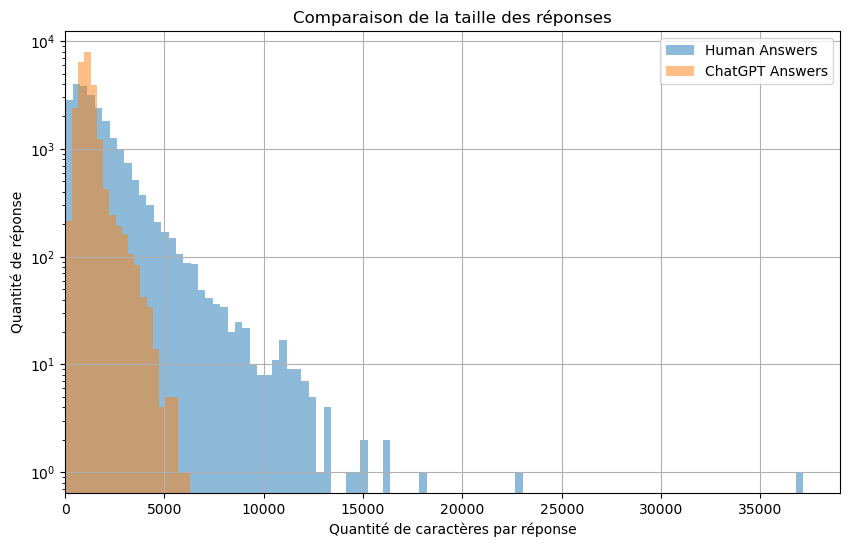

In [22]:
compareLengthAnswer(df_test)

In [23]:
df_wiki = df_test[df_test['source'] == 'wiki_csai']['human_answers']


In [24]:
df_test.head()

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5


### Count number of sentences 

In [25]:
import re
def count_sentences(text):
    # Utiliser regex pour détecter la fin des phrases avec plus de précision
    sentences = re.split(r'(?<=[.!?])\s+', text)
    # Retourner le nombre de phrases, en s'assurant qu'on ne compte pas les éléments vides
    return len([sentence for sentence in sentences if sentence.strip()])

# Appliquer la fonction de comptage sur les colonnes des réponses et créer de nouvelles colonnes pour les comptes
df['human_sentence_count'] = df['human_answers'].apply(count_sentences)
df['chatgpt_sentence_count'] = df['chatgpt_answers'].apply(count_sentences)

# Grouper par la colonne 'source' et calculer la somme des phrases pour chaque source
grouped = df.groupby('source').agg({
    'human_sentence_count': 'sum',
    'chatgpt_sentence_count': 'sum'
}).reset_index()

grouped

,source,human_sentence_count,chatgpt_sentence_count
0,finance,35280,25627
1,medicine,6558,11801
2,open_qa,1351,15928
3,reddit_eli5,322703,124197
4,wiki_csai,6800,6521


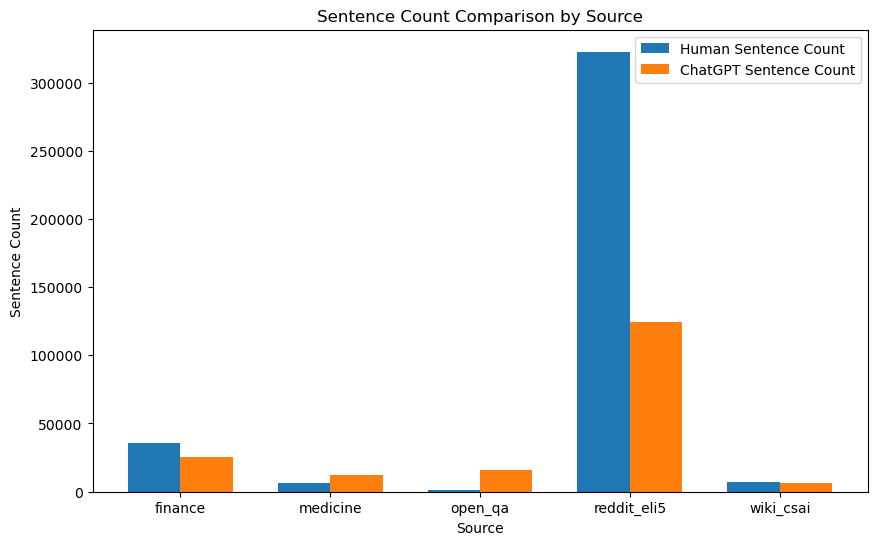

In [26]:
import matplotlib.pyplot as plt
import numpy as np

positions = np.arange(len(grouped['source']))

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35

# Create bars
human_bars = ax.bar(positions - width/2, grouped['human_sentence_count'],width, label='Human Sentence Count')
chatgpt_bars = ax.bar(positions + width/2, grouped['chatgpt_sentence_count'], width, label='ChatGPT Sentence Count')

ax.set_xlabel('Source')
ax.set_ylabel('Sentence Count')
ax.set_title('Sentence Count Comparison by Source')
ax.set_xticks(positions)
ax.set_xticklabels(grouped['source'])
ax.legend()
plt.show()


## Correlation between answers and questions length

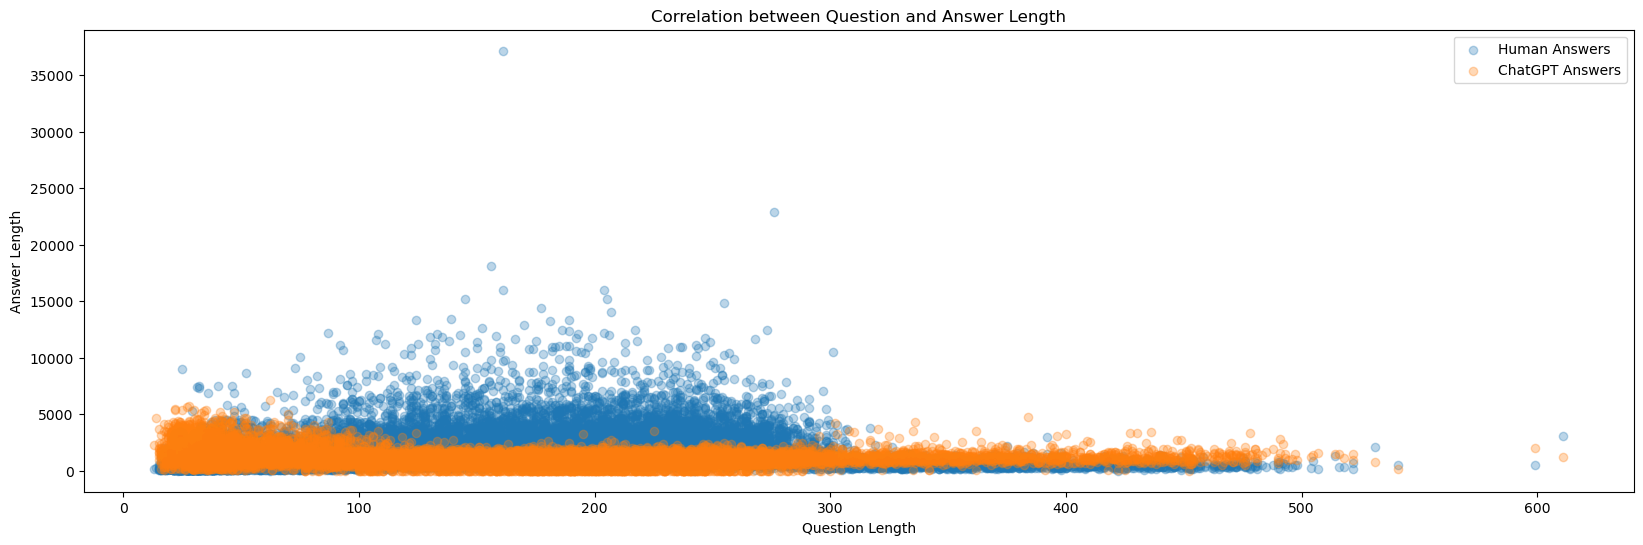

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

df_plot = df.copy()

df_plot['question_length'] = df['question'].apply(len)
df_plot['human_answer_length'] = df['human_answers'].apply(len)
df_plot['chatgpt_answer_length'] = df['chatgpt_answers'].apply(len)

plt.figure(figsize=(20, 6))

# Scatter plot for Q and A
plt.scatter(df_plot['question_length'], df_plot['human_answer_length'], label='Human Answers', alpha=0.3)
plt.scatter(df_plot['question_length'], df_plot['chatgpt_answer_length'], label='ChatGPT Answers', alpha=0.3)

plt.xlabel('Question Length')
plt.ylabel('Answer Length')
plt.title('Correlation between Question and Answer Length')
plt.legend()
plt.show()

## Bag of Words (CountVectorizer) Naives bayes avec MultinomialNB

In [28]:
#Création d'un dataset composé de toutes les phrases avec ces labels
dataset = pd.DataFrame({
    'answers': df['human_answers'].tolist() + df['chatgpt_answers'].tolist(),
    'category': ['human'] * len(df) + ['chatgpt'] * len(df)
})

In [29]:
X = dataset['answers']
Y = dataset['category']

In [30]:
#Training a split dataset avec un poid bien balancé
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)

In [47]:
#Construction de modèle avec un tokenizer et ngram_range correspondant aux mots adjacents

model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (3,3)), MultinomialNB(alpha=4.0, fit_prior=False))

#Construction d'un grid_search pour Naives Bayes
# Define the parameter grid
#param_grid = {
#    'alpha': [1.0, 2.0, 3.0, 4.0],  # Smoothing parameter
#    'fit_prior': [True, False]       # Whether to learn class prior probabilities
#}
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
# Fit the grid search to the data
#grid_search.fit(X_train_counts, Y_train)

# Get the best parameters
#best_params = grid_search.best_params_
#print("Best parameters:", best_params)

In [48]:
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, y_pred))

/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

     chatgpt       0.91      0.98      0.95      4786
       human       0.98      0.91      0.94      4740

    accuracy                           0.95      9526
   macro avg       0.95      0.95      0.95      9526
weighted avg       0.95      0.95      0.95      9526



## Plot confusion matrix

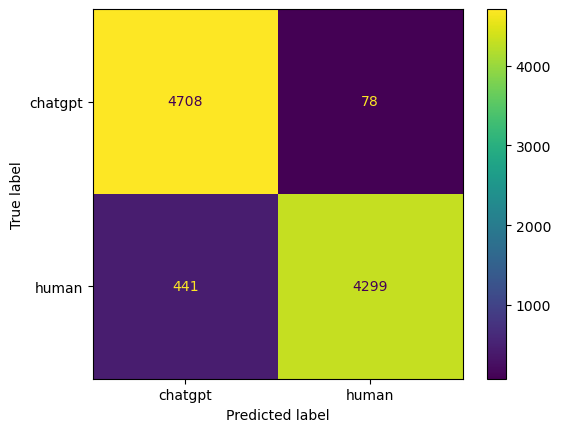

In [49]:
cm = confusion_matrix(Y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

# Cross Validation

In [50]:
# Perform cross-validation and print the mean accuracy
scoring = 'f1_macro'
scores = cross_val_score(model, X, Y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

scores_1 = cross_val_score(model, X, Y, cv=10, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores_1.mean()}")
print(f"Standard deviation {scoring}: {scores_1.std()}")

/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Mean f1_macro: 0.9529099817264136
Standard deviation f1_macro: 0.048881445538729945


/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extr

Mean f1_macro: 0.950458573595883
Standard deviation f1_macro: 0.07698620174319072


# Model Word2Vec

In [51]:
X_list = dataset['answers'].apply(lambda x : x.lower())
X_strings = " ".join(X_list)
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [52]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [53]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

In [54]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [55]:
X = dataset['answers'].apply(lambda x : x.lower())
Y = dataset['category']
X = np.array([document_vector(text, wv) for text in X])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (38100, 50)


In [56]:
model = make_pipeline(LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__max_iter': [100, 200, 300],
    'logisticregression__tol': [1e-4, 1e-3, 1e-2],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, Y_test)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.0001}
Best cross-validation score: 0.8756425594196772


In [58]:
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, y_pred))dsds

SyntaxError: invalid syntax (3096178896.py, line 2)